In [1]:
# Import the necessary packages
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.datasets import mnist
import numpy as np
import pickle
import pandas as pd
from PIL import Image

In [2]:
# Optionally, hardcode the paths (can be overridden by user input in the notebook)
MODEL_PATH = "autoencoder_model.keras"   # Hardcoded model file path
index_path = 'data/index.pkl'  # Hardcoded output index file path

In [3]:
db_data_csv = pd.read_csv("data/database_data.csv")
test_data_csv = pd.read_csv("data/test_data.csv")

In [4]:
db_data_csv.shape

(15000, 23)

In [5]:
num_images = len(db_data_csv)
image_shape = (128, 128, 3)

db_data = np.empty((num_images, *image_shape), dtype=np.uint8)

for i in range(num_images):
    image_path = db_data_csv.iloc[i]['cutOutImages_path']
    
    # Open image and resize to (32, 32)
    # img = Image.open(image_path).resize((32, 32))  # Resize to uniform shape
    img = Image.open(image_path).resize((128, 128), Image.Resampling.BILINEAR)
    # If the image is grayscale (L mode), convert it to RGB
    if img.mode != 'RGB':
        img = img.convert('RGB')
    
    # Convert the image to a numpy array
    img_array = np.array(img)
    
    # Ensure it's in the desired shape (32, 32, 3)
    if img_array.shape != image_shape:
        raise ValueError(f"Image at {image_path} has shape {img_array.shape}, expected {image_shape}")

    # Add to pre-allocated array
    db_data[i] = img_array

print(db_data.shape)  # (50000, 32, 32, 3)

(15000, 128, 128, 3)


In [6]:
print("[INFO] loading autoencoder model...")
autoencoder = load_model(MODEL_PATH)

[INFO] loading autoencoder model...


In [8]:
# Create the encoder model, consisting of only the encoder portion of the autoencoder
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer("latent_vector").output)

In [17]:
# Quantify the contents of our input images using the encoder
print("[INFO] Encoding images...")
db_vectors = encoder.predict(db_data)


[INFO] Encoding images...
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step


In [18]:
len(db_vectors)

15000

In [11]:
# image to its corresponding latent-space representation
indexes = list(range(0, db_data.shape[0]))
data = {"indexes": indexes, "features": features}

In [12]:
# Write the data dictionary to disk
print("[INFO] Saving index...")
with open(index_path, "wb") as f:
    pickle.dump(data, f)

print("[INFO] Process completed. Encoded features saved to:", index_path)

[INFO] Saving index...
[INFO] Process completed. Encoded features saved to: data/index.pkl


In [13]:
num_images = len(test_data_csv)
image_shape = (128, 128, 3)

test_data = np.empty((num_images, *image_shape), dtype=np.uint8)

for i in range(num_images):
    image_path = test_data_csv.iloc[i]['cutOutImages_path']
    
    # Open image and resize to (32, 32)
    # img = Image.open(image_path).resize((32, 32))  # Resize to uniform shape
    img = Image.open(image_path).resize((128, 128), Image.Resampling.BILINEAR)
    # If the image is grayscale (L mode), convert it to RGB
    if img.mode != 'RGB':
        img = img.convert('RGB')
    
    # Convert the image to a numpy array
    img_array = np.array(img)
    
    # Ensure it's in the desired shape (32, 32, 3)
    if img_array.shape != image_shape:
        raise ValueError(f"Image at {image_path} has shape {img_array.shape}, expected {image_shape}")

    # Add to pre-allocated array
    test_data[i] = img_array

print(test_data.shape)  # (50000, 32, 32, 3)

(7500, 128, 128, 3)


In [25]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

def testModelusingvalidationData(index):
    
    # Testing the architectures on external images
    
    '''Read the inserted url'''
    

    testing_features = encoder.predict(test_data[index:index+1])
    
    similarity_images_vgg = {}
    for idx, features in enumerate(db_vectors):

        # Compute the similarity using Euclidean Distance
        similarity_images_vgg[idx] = np.sum((testing_features - features)**2) ** 0.5

    # Extracting the top 10 similar images
    similarity_vgg_sorted = sorted(similarity_images_vgg.items(), key = lambda x : x[1], reverse=False)
    top_10_indexes_vgg = [idx for idx, _ in similarity_vgg_sorted][ : 10]
    
    # Plotting the images
    top_10_similar_imgs_VGG = db_data_csv.iloc[top_10_indexes_vgg]['cutOutImages_path']
    brand_VGG = db_data_csv.iloc[top_10_indexes_vgg]['brand.name']
    
    print("===================== QUERY IMAGE ==========================")
    plt.figure(figsize=(8,8))
    # testing_img_arr = image.img_to_array(testing_img, dtype='int')
    # plt.imshow(test_data_csv.iloc[index]['cutOutImages_path'])
    image_path = test_data_csv.iloc[index]['cutOutImages_path']
    image_features = Image.open(image_path)

    # Convert the image to a numpy array (optional, for consistency)
    image_arr = np.array(image_features)

    # Display the image
    plt.imshow(image_arr)
    plt.axis('off')
    plt.show()
    print("=============================================================")

    fig = plt.figure(figsize=(15,5))
    print("===================== SIMILAR IMAGES ==========================")
    for i, (img_path, brand) in enumerate(zip(top_10_similar_imgs_VGG, brand_VGG)):
        plt.subplot(2, 5, i+1)
        img = image.load_img(img_path)
        img_arr = image.img_to_array(img, dtype='int')
        plt.imshow(img_arr)
        # plt.xlabel(price)
        plt.title(brand)
        plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
===================== QUERY IMAGE ==========================


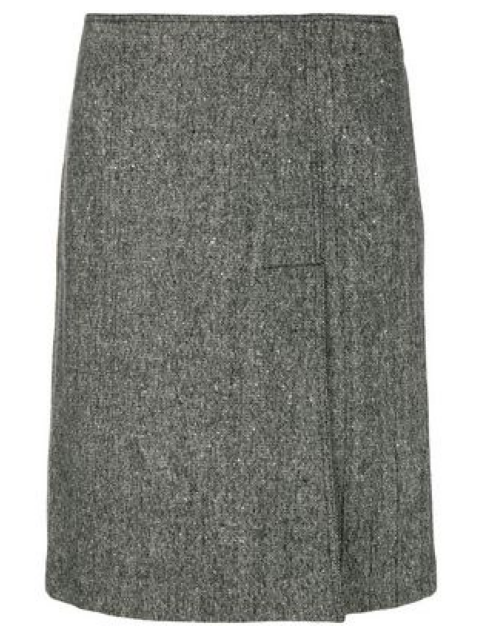

===================== SIMILAR IMAGES ==========================


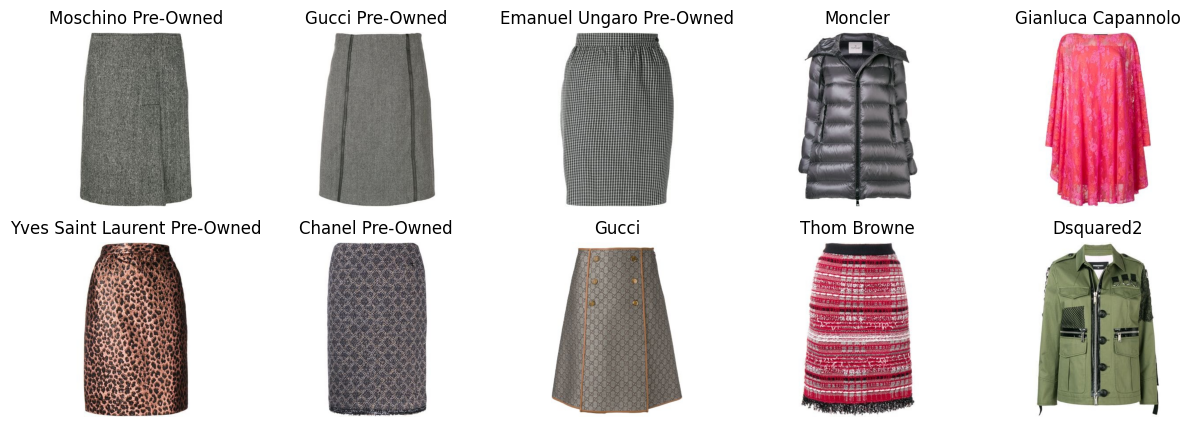

In [28]:
testModelusingvalidationData(55)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
===================== QUERY IMAGE ==========================


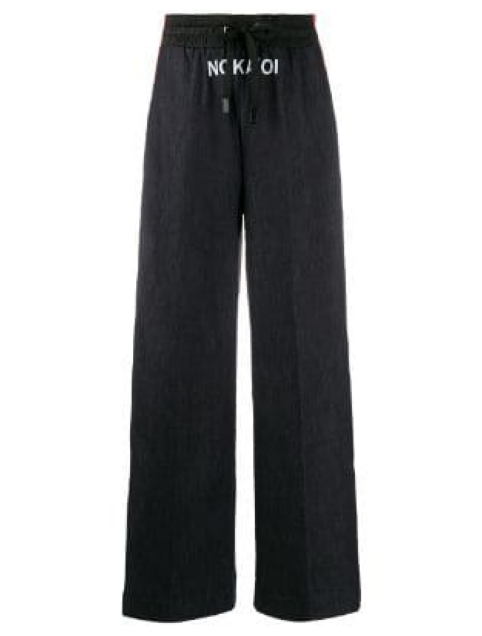

===================== SIMILAR IMAGES ==========================


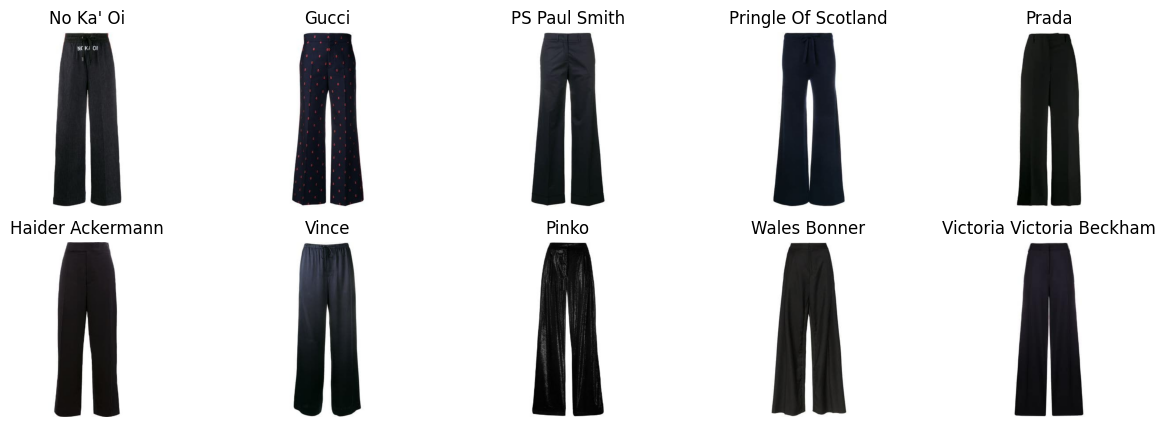

In [29]:
testModelusingvalidationData(551)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
===================== QUERY IMAGE ==========================


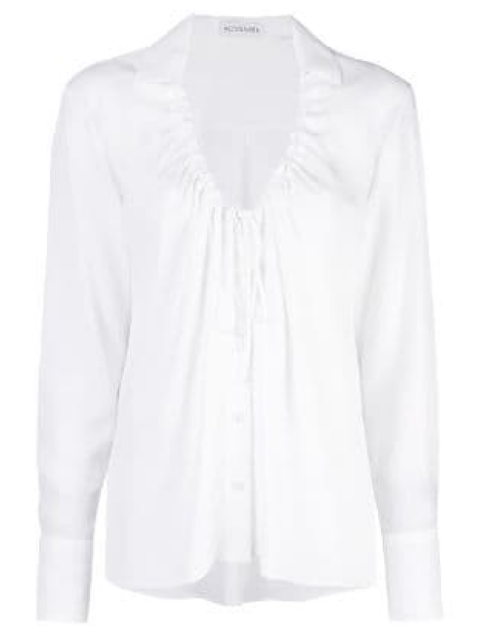

===================== SIMILAR IMAGES ==========================


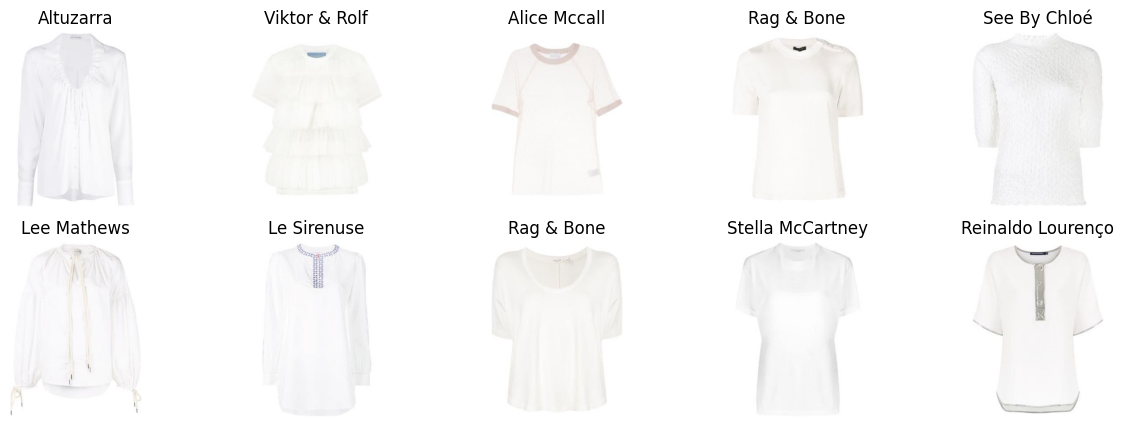

In [30]:
testModelusingvalidationData(255)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
===================== QUERY IMAGE ==========================


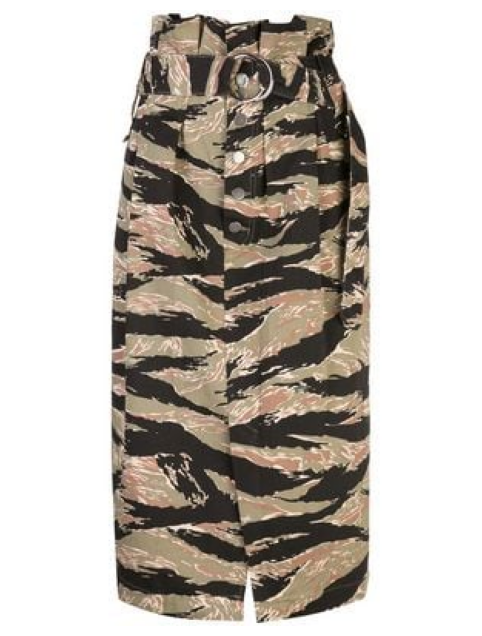

===================== SIMILAR IMAGES ==========================


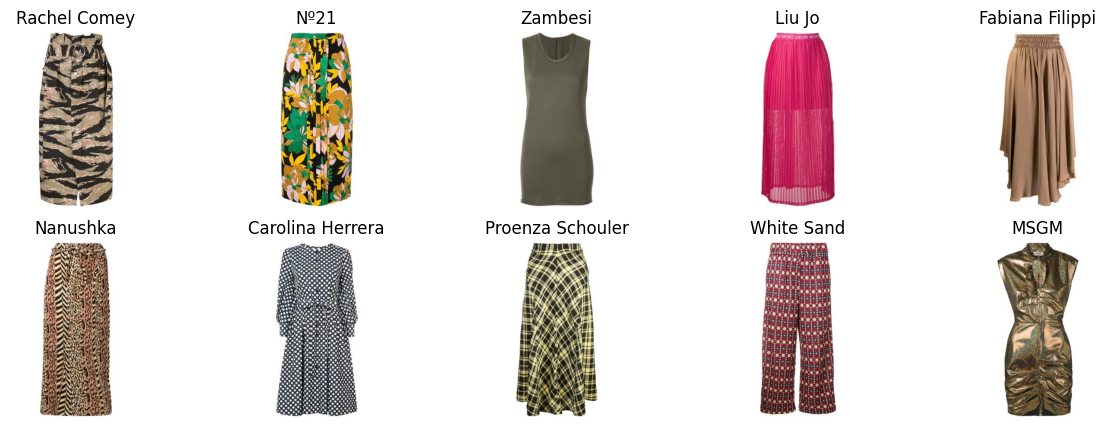

In [35]:
testModelusingvalidationData(1111)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
===================== QUERY IMAGE ==========================


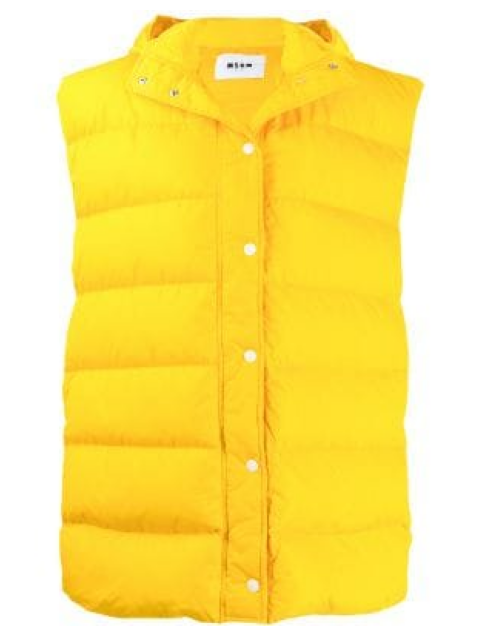

===================== SIMILAR IMAGES ==========================


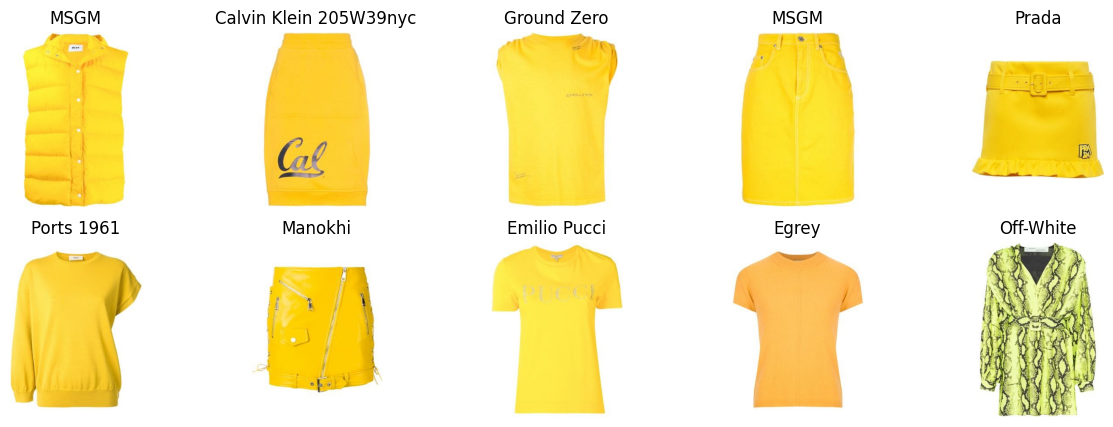

In [36]:
testModelusingvalidationData(2111)